# AAPL Preprocessing

In [1]:
import numpy as np
import time
import datetime
import pandas as pd
from pandas.tseries.offsets import BMonthEnd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
crsp = pd.read_csv('AAPL.csv',index_col='date')
crsp.drop(columns=['PERMNO', 'RETX'], inplace=True)
crsp

,BIDLO,ASKHI,PRC,VOL,RET,OPENPRC
date,,,,,,
1980-12-12,28.75000,28.87500,-28.81250,NaN,C,NaN
1980-12-15,27.25000,27.37500,-27.31250,NaN,-0.052061,NaN
1980-12-16,25.25000,25.37500,-25.31250,NaN,-0.073227,NaN
1980-12-17,25.87500,26.00000,-25.93750,NaN,0.024691,NaN
1980-12-18,26.62500,26.75000,-26.68750,NaN,0.028916,NaN
...,...,...,...,...,...,...
2024-12-24,255.28999,258.20999,258.20001,23146511.0,0.011478,255.49001
2024-12-26,257.63000,260.10001,259.01999,27065955.0,0.003176,258.19000
2024-12-27,253.06000,258.70001,255.59000,42079549.0,-0.013242,257.82999


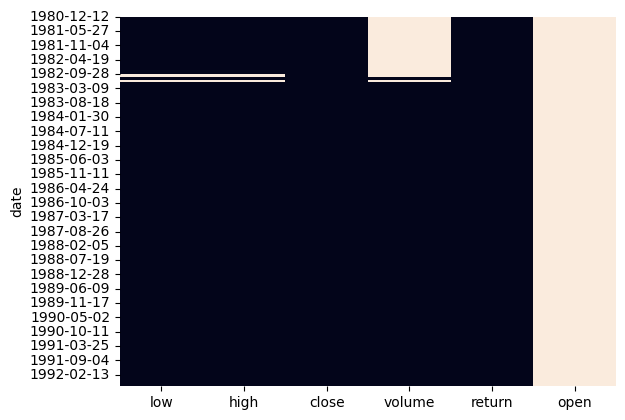

low         43
high        43
close        1
volume     499
return       1
open      2917
dtype: int64

In [3]:
crsp.columns = ['low', 'high', 'close', 'volume', 'return', 'open'] # rename columns 

# plot missing values
sns.heatmap(crsp.iloc[np.unique\
    (np.where(crsp.isnull())[0]),:]\
    .isnull(),cbar=False)
plt.show()

# count number of missing values
crsp.isnull().sum()

In [4]:
# filter data from first date after which there are no missing values
first_valid_date = crsp.notna().all(axis=1).idxmax()
crsp = crsp[crsp.index >= first_valid_date]

# convert all entries to float and make all prices positive
crsp = crsp.map(lambda x: float(x) if x is not None else None)
for col in ['open', 'high', 'low', 'close']:
    crsp[col] = pd.to_numeric(crsp[col], errors='coerce').abs()
crsp

,low,high,close,volume,return,open
date,,,,,,
1992-06-15,52.50000,54.00000,52.62500,1674644.0,-0.036613,54.00000
1992-06-16,48.75000,52.00000,49.25000,3314828.0,-0.064133,51.75000
1992-06-17,47.00000,49.25000,47.50000,2719955.0,-0.035533,49.00000
1992-06-18,44.75000,49.00000,45.25000,3925309.0,-0.047368,47.50000
1992-06-19,43.75000,46.00000,44.75000,3818924.0,-0.011050,46.00000
...,...,...,...,...,...,...
2024-12-24,255.28999,258.20999,258.20001,23146511.0,0.011478,255.49001
2024-12-26,257.63000,260.10001,259.01999,27065955.0,0.003176,258.19000
2024-12-27,253.06000,258.70001,255.59000,42079549.0,-0.013242,257.82999


In [5]:
# Create adjusted close prices using total return
growth = 1.0 + crsp['return']
base_close_raw = crsp['close'].iloc[0]
crsp_adj = crsp.copy()
crsp_adj['close'] = base_close_raw * growth.cumprod()

# Scale open, high, low to preserve ratios to unadjusted close
scale = crsp_adj['close'] / crsp['close'].replace(0, np.nan)
scale = scale.replace([np.inf, -np.inf], np.nan).ffill().fillna(1.0)
crsp_adj['open'] = crsp_adj['open'] * scale
crsp_adj['high'] = crsp_adj['high'] * scale
crsp_adj['low'] = crsp_adj['low'] * scale
crsp_adj

,low,high,close,volume,return,open
date,,,,,,
1992-06-15,50.577817,52.022898,50.698241,1674644.0,-0.036613,52.022898
1992-06-16,46.965117,50.096125,47.446811,3314828.0,-0.064133,49.855278
1992-06-17,45.279190,47.446810,45.760883,2719955.0,-0.035533,47.205964
1992-06-18,43.111588,47.205984,43.593282,3925309.0,-0.047368,45.760903
1992-06-19,42.148189,44.315810,43.111576,3818924.0,-0.011050,44.315810
...,...,...,...,...,...,...
2024-12-24,34062.849189,34452.459136,34451.127524,23146511.0,0.011478,34089.537470
2024-12-26,34375.080585,34704.649318,34560.544305,27065955.0,0.003176,34449.800319
2024-12-27,33765.320430,34517.856370,34102.893577,42079549.0,-0.013242,34401.771235


In [ ]:
def transform_price_series_fintsbridge(window_df, price_cols=["open", "high", "low", "close"]):
    """
    FinTSBridge-style price series preprocessing.
    Applies log-relative transformation to price columns (open, high, low, close),
    anchoring each series to the initial close price in the window and shifting by +100.
    Also applies log(1 + volume) transformation to the volume column.

    Formula:
        z_price[t] = log(P[t] / P_close[0]) + 100
        z_volume[t] = log(volume[t] + 1)

    Parameters
    ----------
    df : pd.DataFrame
        A single rolling window (e.g. 60 days) of raw price and volume data.
        Must include 'close' as well as the specified price_cols and 'volume'.

    price_cols : list of str, default=["open", "high", "low", "close"]
        The price columns to transform.

    Returns
    -------
    pd.DataFrame
        A new DataFrame with transformed price and volume columns.
        Output column names will be prefixed with `z_` (e.g. 'z_open', 'z_volume').
    """

    p0_close = window_df.iloc[0]["close"]  # Anchor price at start of window
    transformed = {}
    for col in price_cols:
        transformed[f"z_{col}"] = np.log(window_df[col] / p0_close) + 100
    transformed["z_volume"] = np.log(window_df["volume"] + 1)
    return pd.DataFrame(transformed, index=window_df.index)
    

In [7]:
crsp_transformed = transform_price_series_fintsbridge(crsp_adj)

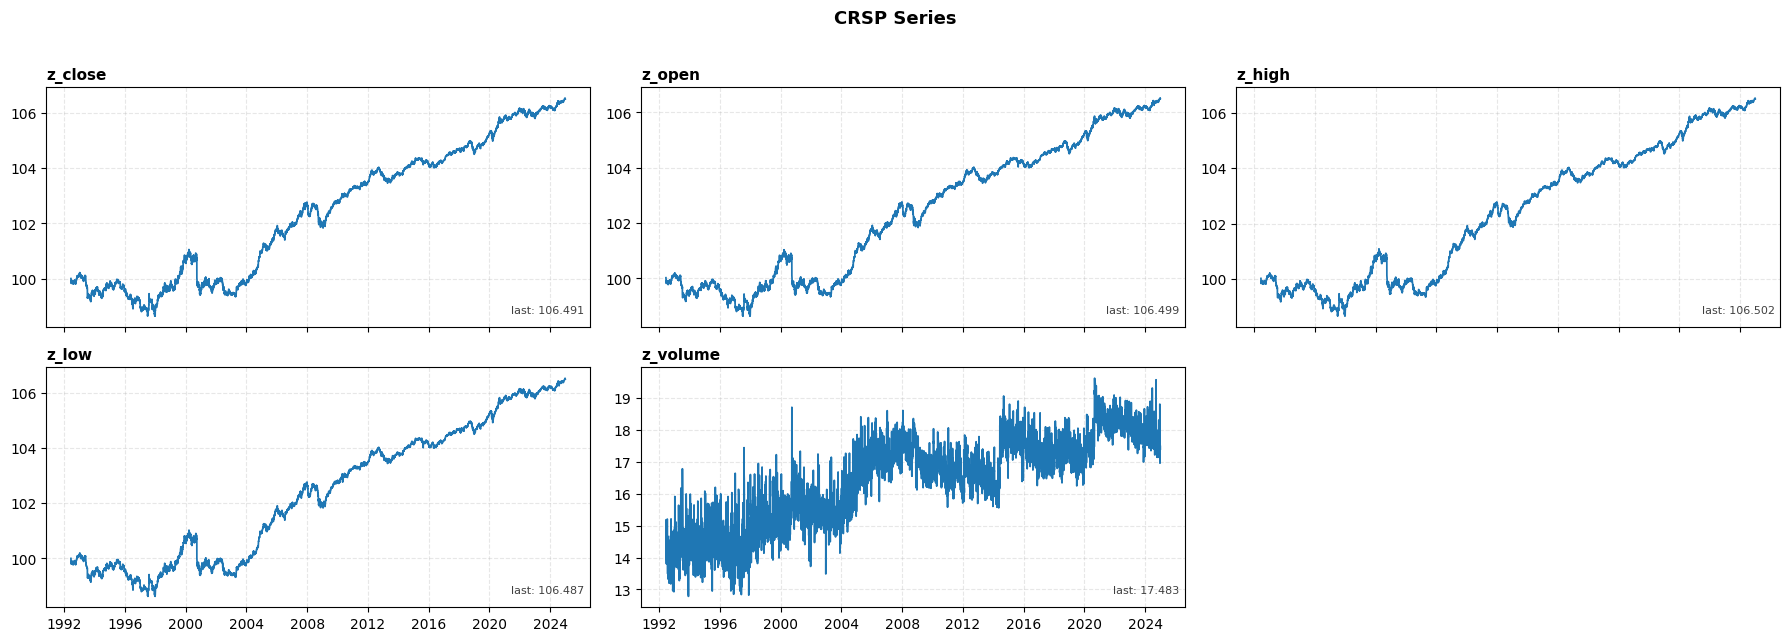

In [ ]:
def plot_crsp(crsp, candidates = ["return", "z_close", "z_open", "z_high", "z_low", "z_volume"], title_prefix="CRSP Series"):
    df = crsp.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df.sort_index()

    cols = [c for c in candidates if c in df.columns]
    n = len(cols)
    ncols = 3 if n <= 6 else 4
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 3.2 * nrows), sharex=True)
    axes = np.array(axes).ravel()

    for i, c in enumerate(cols):
        ax = axes[i]
        s = df[c].dropna()
        ax.plot(s.index, s.values, linewidth=1.25)
        ax.set_title(c, loc="left", fontsize=11, fontweight="bold")
        ax.grid(True, linestyle="--", alpha=0.3)
        if len(s):
            ax.text(0.99, 0.05, f"last: {s.iloc[-1]:.3f}",
                    transform=ax.transAxes, ha="right", va="bottom",
                    fontsize=8, alpha=0.75)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"{title_prefix}", y=0.995, fontsize=13, fontweight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
plot_crsp(crsp_transformed)


In [12]:
# export crsp
crsp.to_csv('AAPL_preprocessed.csv')